In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pickle
from BayesianLasso import BayesianLasso

In [2]:
# Load the generated datasets
filename = "Data/CorrelatedSets50x70x6.pickle"

with open(filename,"rb") as file:
    datasets, responses = pickle.load(file)

In [3]:
datasets.shape, responses.shape

((50, 70, 6), (50, 70, 1))

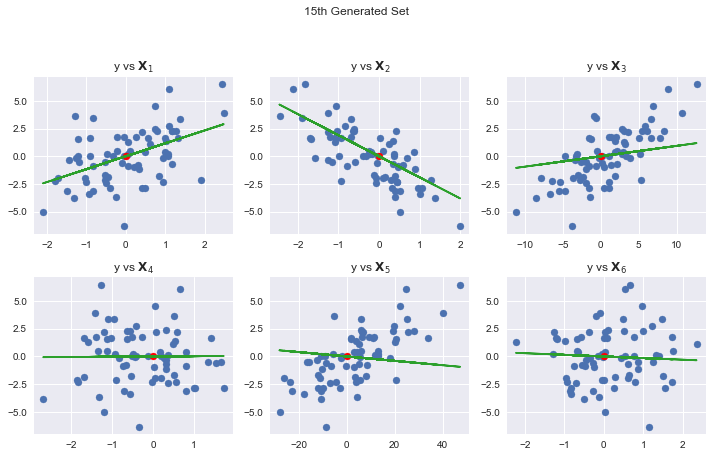

OLS Estimates (Dataset 15): [ 1.16595382 -1.89962669  0.09358939  0.02433709 -0.01979249 -0.14604429]


In [6]:
# Plot for the 15th generated sets with OLS best fit lines
plt.style.use("seaborn")

LinearModel15 = sm.OLS(responses[14]-np.mean(responses[14]),datasets[14])
results15 = LinearModel15.fit()
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
for row in range(1,3):
    for col in range(1,4):
        ax[row-1][col-1].scatter(datasets[14,:,3*(row-1)+col-1],responses[14]-np.mean(responses[14]))
        ax[row-1][col-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+col}}}$")
        ax[row-1][col-1].plot(datasets[14,:,3*(row-1)+col-1],datasets[14,:,3*(row-1)+col-1]*results15.params[3*(row-1)+col-1],color="tab:green")
        ax[row-1][col-1].scatter(0,0,color="r")

fig.suptitle("15th Generated Set",y=1.05)
plt.tight_layout()
plt.show()

print("OLS Estimates (Dataset 15):", results15.params)

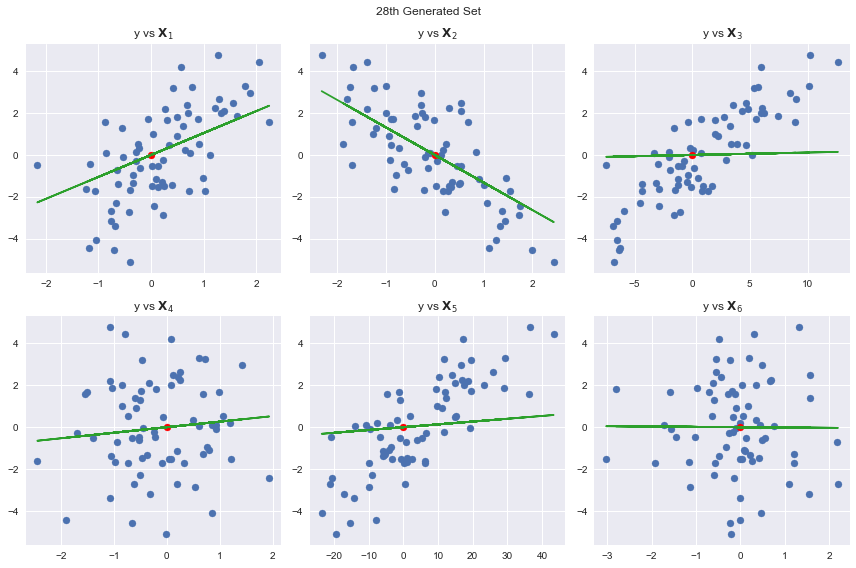

OLS Estimates (Dataset 28): [ 1.0483318  -1.31319327  0.01167059  0.26492782  0.01342192 -0.01527332]


In [10]:
# Plot for the 28th generated sets with OLS best fit lines
LinearModel28 = sm.OLS(responses[27]-np.mean(responses[27]),datasets[27])
results28 = LinearModel28.fit()

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
for row in range(1,3):
    for col in range(1,4):
        ax[row-1][col-1].scatter(datasets[27,:,3*(row-1)+col-1],responses[27] - np.mean(responses[27]))
        ax[row-1][col-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+col}}}$")
        ax[row-1][col-1].plot(datasets[27,:,3*(row-1)+col-1],datasets[27,:,3*(row-1)+col-1]*results28.params[3*(row-1)+col-1],color="tab:green")
        ax[row-1][col-1].scatter(0,0,color="r")
        
fig.suptitle("28th Generated Set")
plt.tight_layout()
plt.show()

print("OLS Estimates (Dataset 28):", results28.params)

In [12]:
"""(1) Find LambdaMML for all datasets and find posterior distributions with this fixed lambda"""

'(1) Find LambdaMML for all datasets and find posterior distributions with this fixed lambda'

In [13]:
N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesMML = np.zeros((num_datasets,N,p))
sig2TracesMML = np.zeros((num_datasets,N))
tau2TracesMML = np.zeros((num_datasets,N,p))

# Create space for the lambda MML estimates for each dataset
lambdaMMLs = np.zeros((num_datasets,1))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Find marginal maximum likelihood estimate for lambda
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    _, lambdaMML_i = bLasso_i.lambda_MML(gibbs_iter=7500,em_iter=15)
    # Find Bayesian Lasso traces corresponding to the MML estimate of lambda
    lambdaMMLs[datasetidx] = lambdaMML_i
    betaTracesMML[datasetidx], sig2TracesMML[datasetidx], tau2TracesMML[datasetidx] = bLasso_i.gibbs_fixedLam(lambdaMML_i,n_iter=N)

0
10
20
30
40


In [14]:
betaBurnedTracesMML = betaTracesMML[:,burnin:,:]
sig2BurnedTracesMML = sig2TracesMML[:,burnin:]
tau2BurnedTracesMML = tau2TracesMML[:,burnin:,:]
betaBurnedTracesMML.shape,sig2BurnedTracesMML.shape,tau2BurnedTracesMML.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6))

In [15]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansMML = np.median(betaBurnedTracesMML,axis=1)
print(burnedBetaMediansMML.shape)

(50, 6)


In [16]:
# For each dataset, find lasso and ridge estimates chosen by cross validation
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, LinearRegression

lassoCoefficientsCV = np.zeros((num_datasets,p))
ridgeCoefficientsCV = np.zeros((num_datasets,p))

lambdaLassoCVs = np.zeros((num_datasets,1))
lambdaRidgeCVs = np.zeros((num_datasets,1))

for idx, dataset in enumerate(datasets):
    # standardise design matrix
    stdX = (dataset - np.mean(dataset,axis=0))/np.std(dataset,axis=0)
    lassoCVmodel = LassoCV(cv=7,fit_intercept=False,max_iter=10000)
    lassoCVmodel.fit(stdX,np.ravel(responses[idx]-np.mean(responses[idx])))
    ridgeCVmodel = RidgeCV(cv=7,fit_intercept=False,alphas=lassoCVmodel.alphas_*10)
    ridgeCVmodel.fit(stdX,np.ravel(responses[idx]-np.mean(responses[idx])))
    
    lassoCoefficientsCV[idx] = np.reshape(lassoCVmodel.coef_,(1,p))
    ridgeCoefficientsCV[idx] = np.reshape(ridgeCVmodel.coef_,(1,p))
    
    lambdaLassoCVs[idx] = lassoCVmodel.alpha_*2*n
    lambdaRidgeCVs[idx] = ridgeCVmodel.alpha_

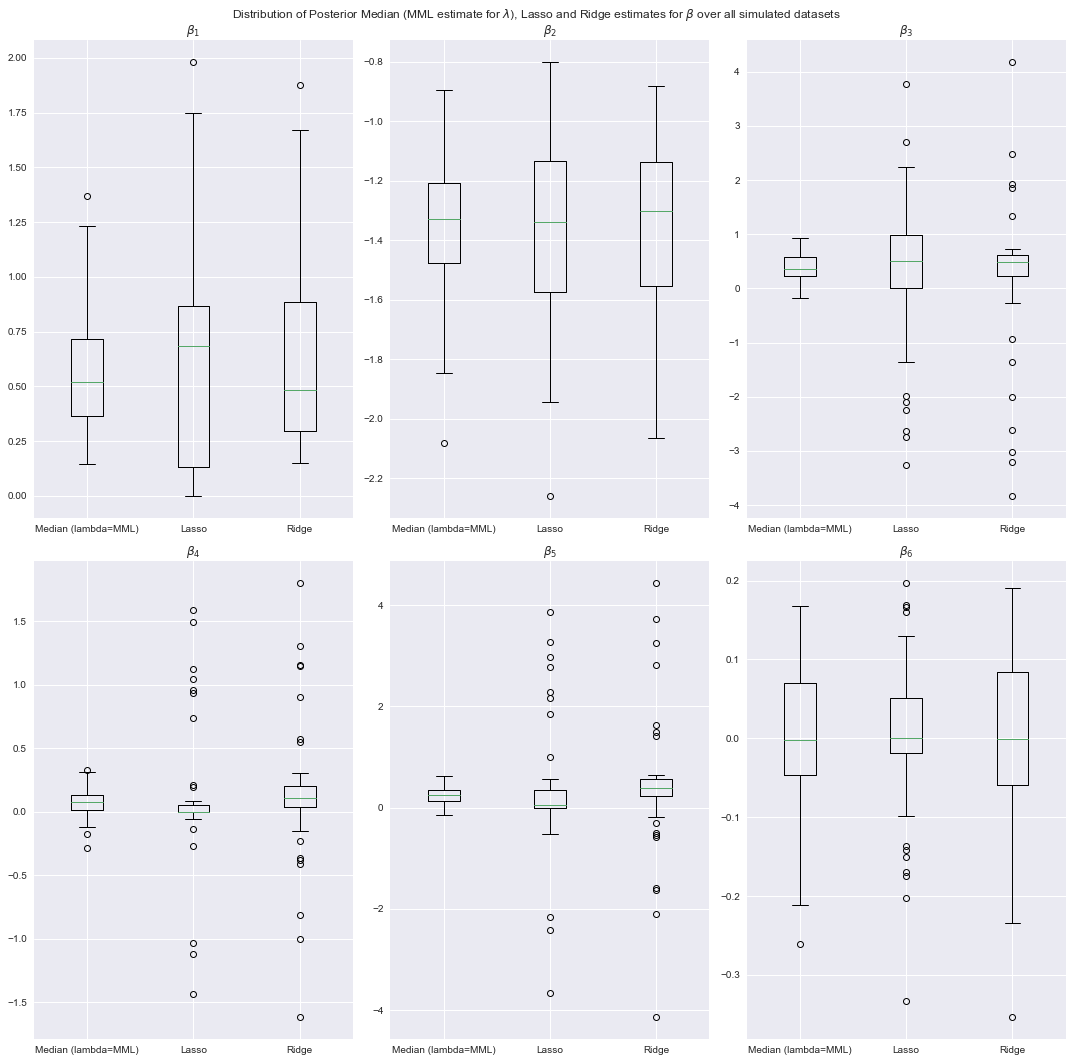

In [17]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (at lambdaMML) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansMML[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (lambda=MML)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (MML estimate for $\lambda$), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [18]:
"""(2) For each dataset, rescale the lambda chosen by CV. i.e. set lam_rescaled = lamCV/2s. Use this as a fixed Lambda in gibbs"""

'(2) For each dataset, rescale the lambda chosen by CV. i.e. set lam_rescaled = lamCV/2s. Use this as a fixed Lambda in gibbs'

In [19]:
N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesCV = np.zeros((num_datasets,N,p))
sig2TracesCV = np.zeros((num_datasets,N))
tau2TracesCV = np.zeros((num_datasets,N,p))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Rescale lambda
    linearmodel = sm.OLS(responses[datasetidx]-np.mean(responses[datasetidx]),stdX).fit()
    RSS = np.sum(linearmodel.resid**2)
    s2 = RSS/(n-p)
    rescaledLambdaCV = lambdaLassoCVs[datasetidx]/(2*np.sqrt(s2))
    # Find Bayesian Lasso traces corresponding to the CV estimate of lambda
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesCV[datasetidx], sig2TracesCV[datasetidx], tau2TracesCV[datasetidx] = bLasso_i.gibbs_fixedLam(rescaledLambdaCV,n_iter=N)

0
10
20
30
40


In [20]:
betaBurnedTracesCV = betaTracesCV[:,burnin:,:]
sig2BurnedTracesCV = sig2TracesCV[:,burnin:]
tau2BurnedTracesCV = tau2TracesCV[:,burnin:,:]
betaBurnedTracesCV.shape,sig2BurnedTracesCV.shape,tau2BurnedTracesCV.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6))

In [21]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansCV = np.median(betaBurnedTracesCV,axis=1)
print(burnedBetaMediansCV.shape)

(50, 6)


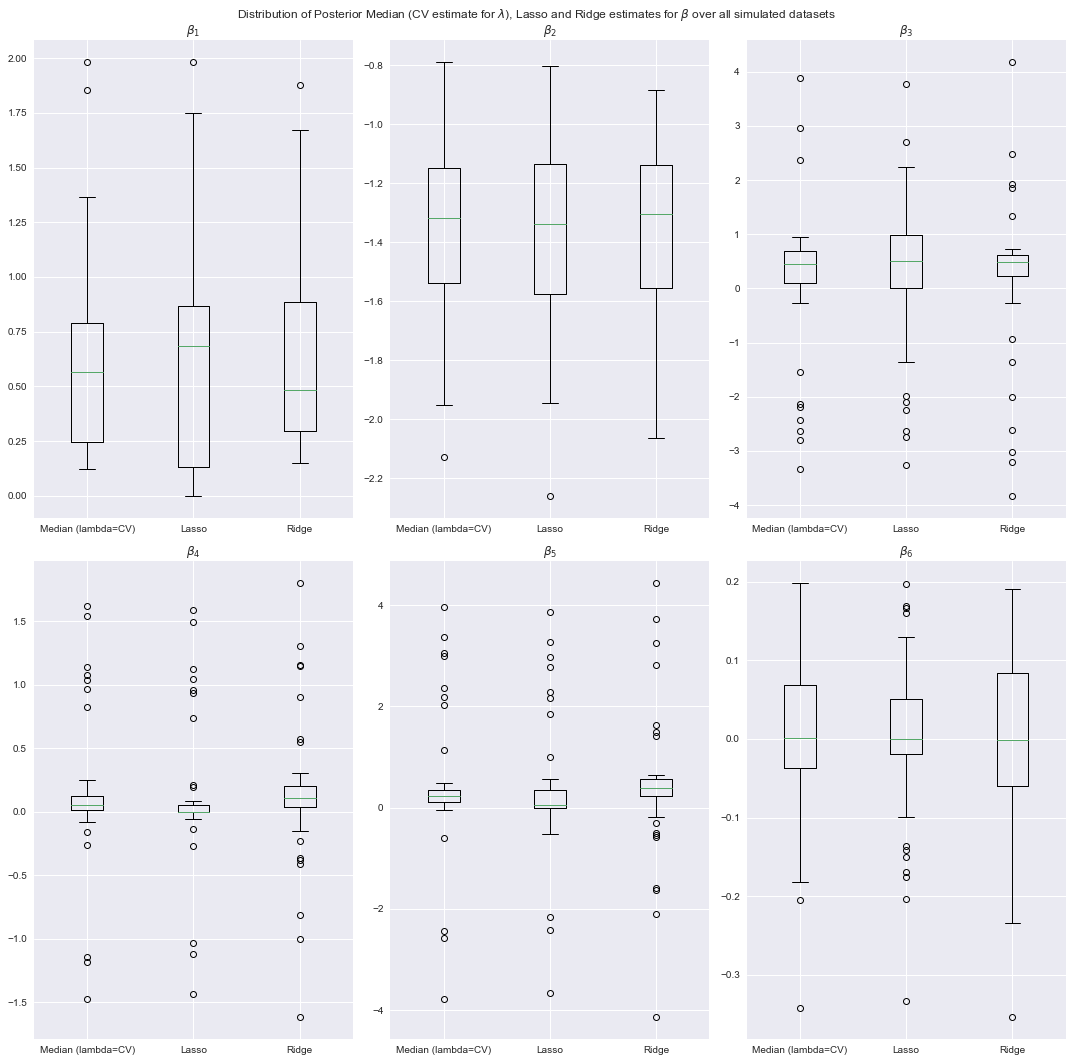

In [22]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (at lambdaCV) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansCV[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (lambda=CV)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (CV estimate for $\lambda$), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [23]:
"""(3) Set a naive Gamma(0.01,0.01) prior on lambda^{2}"""

'(3) Set a naive Gamma(0.01,0.01) prior on lambda^{2}'

In [24]:
# Naive Gamma prior with r = 0.01, delta = 0.01
# This gamma distribution has mean 1 and variance 100
# Large mass around smaller lambdas - reflecting small bias variance trade off, as well as allowing for possible larger values

N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesNaive = np.zeros((num_datasets,N,p))
sig2TracesNaive = np.zeros((num_datasets,N))
tau2TracesNaive = np.zeros((num_datasets,N,p))
lambdaTracesNaive = np.zeros((num_datasets,N))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix 
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Find Bayesian Lasso traces using the naive gamma hyperprior for lambda
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesNaive[datasetidx], sig2TracesNaive[datasetidx], tau2TracesNaive[datasetidx], lambdaTracesNaive[datasetidx]  = bLasso_i.gibbs_gammaHPrior(n_iter=N) 

0
10
20
30
40


In [25]:
betaBurnedTracesNaive = betaTracesNaive[:,burnin:,:]
sig2BurnedTracesNaive = sig2TracesNaive[:,burnin:]
tau2BurnedTracesNaive = tau2TracesNaive[:,burnin:,:]
lambdaBurnedTracesNaive = lambdaTracesNaive[:,burnin:]
betaBurnedTracesNaive.shape,sig2BurnedTracesNaive.shape,tau2BurnedTracesNaive.shape,lambdaBurnedTracesNaive.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6), (50, 5500))

In [26]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansNaive = np.median(betaBurnedTracesNaive,axis=1)
print(burnedBetaMediansNaive.shape)

(50, 6)


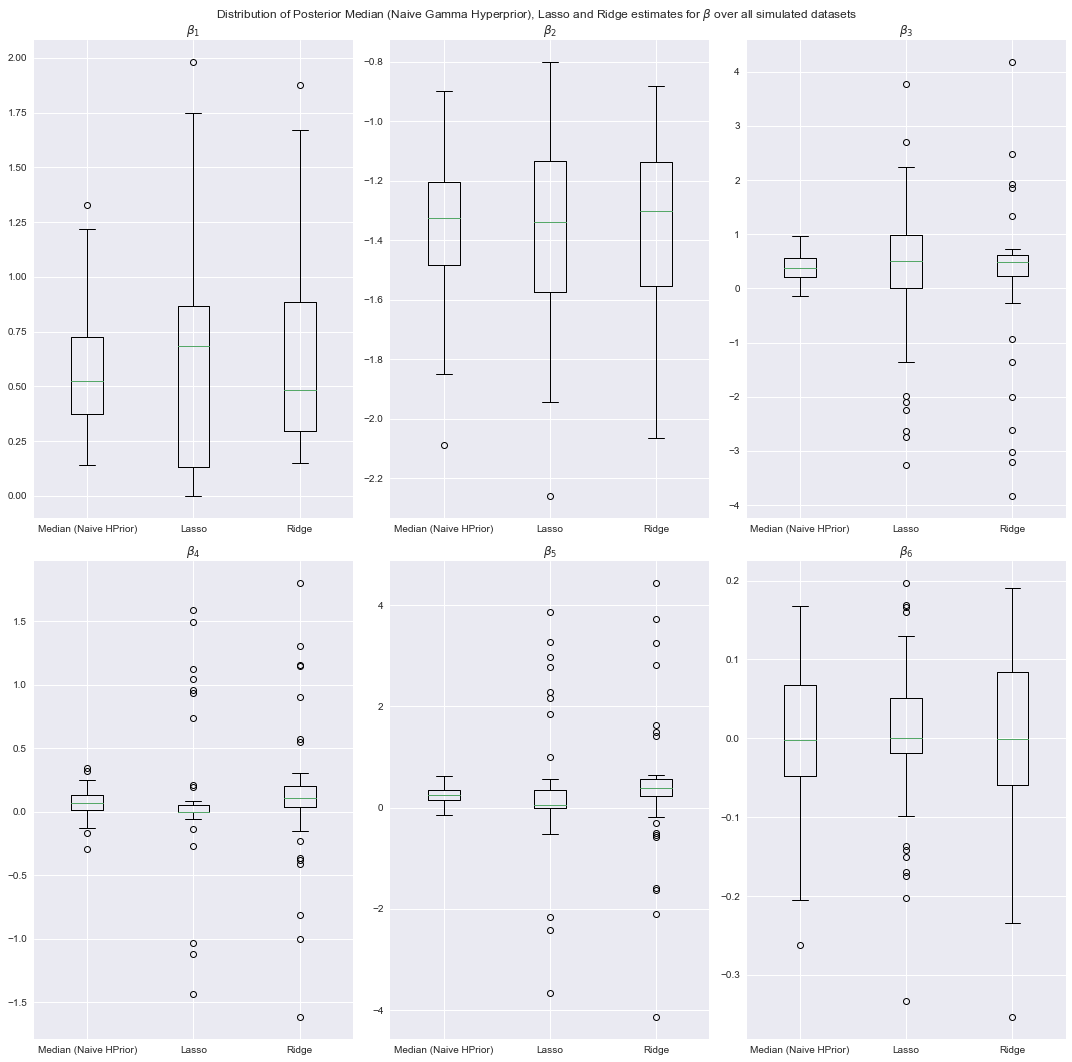

In [27]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (Naive Gamma Hyperprior) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansNaive[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (Naive HPrior)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (Naive Gamma Hyperprior), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [ ]:
"""(4) Set an Exponential Hyperprior for lambda^2 with mean = squared MML estimate"""

In [28]:
# (4) Exponential prior (r=1 in gamma prior) with mean equal to the square of the MML estimate
# (4) r = 1, delta = 1/lambdaMML^2

N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesExpMML = np.zeros((num_datasets,N,p))
sig2TracesExpMML = np.zeros((num_datasets,N))
tau2TracesExpMML = np.zeros((num_datasets,N,p))
lambdaTracesExpMML = np.zeros((num_datasets,N))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Find Bayesian Lasso traces using the Exponential prior for lambda**2 with mean at the squared MML estimate
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesExpMML[datasetidx], sig2TracesExpMML[datasetidx], tau2TracesExpMML[datasetidx], lambdaTracesExpMML[datasetidx]  = bLasso_i.gibbs_gammaHPrior(r=1,delta=1/(lambdaMMLs[datasetidx]**2),n_iter=N) 

0
10
20
30
40


In [29]:
betaBurnedTracesExpMML = betaTracesExpMML[:,burnin:,:]
sig2BurnedTracesExpMML = sig2TracesExpMML[:,burnin:]
tau2BurnedTracesExpMML = tau2TracesExpMML[:,burnin:,:]
lambdaBurnedTracesExpMML = lambdaTracesExpMML[:,burnin:]
betaBurnedTracesExpMML.shape,sig2BurnedTracesExpMML.shape,tau2BurnedTracesExpMML.shape,lambdaBurnedTracesExpMML.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6), (50, 5500))

In [30]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansExpMML = np.median(betaBurnedTracesExpMML,axis=1)
print(burnedBetaMediansExpMML.shape)

(50, 6)


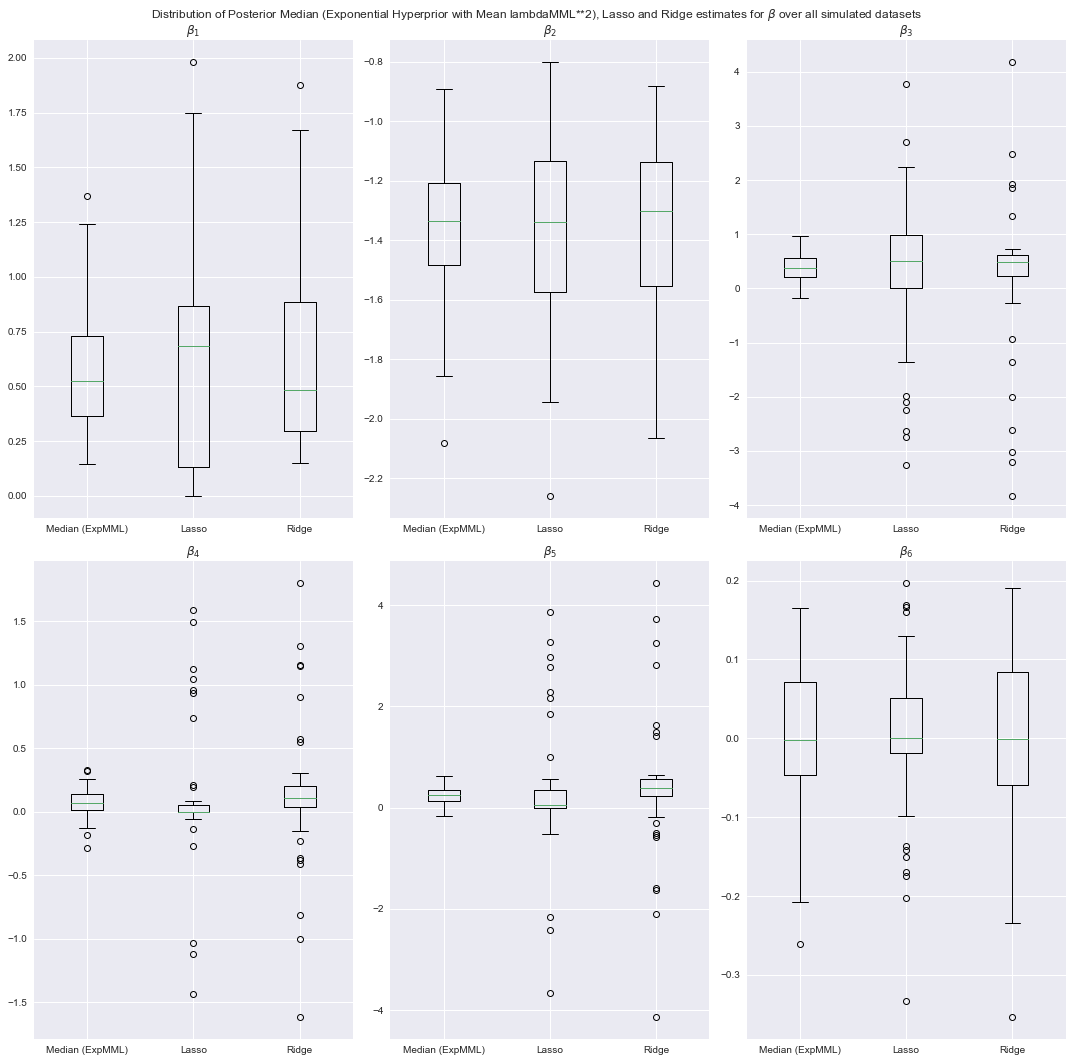

In [31]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (Exp Hyperprior with mean lambdaMML**2) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansExpMML[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (ExpMML)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (Exponential Hyperprior with Mean lambdaMML**2), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [32]:
"""(5) Set an Exponential Hyperprior for lambda^2 with mean = squared rescaled CV estimate"""

'(5) Set an Exponential Hyperprior for lambda^2 with mean = squared rescaled CV estimate'

In [33]:
# (5) Exponential prior (r=1 in gamma prior) with mean equal to the square of the rescaled CV estimate
# lam = lambdaCV/2s 
# mean = 1/delta = lam^2 implying delta = 1/lam^2

N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesExpCV = np.zeros((num_datasets,N,p))
sig2TracesExpCV = np.zeros((num_datasets,N))
tau2TracesExpCV = np.zeros((num_datasets,N,p))
lambdaTracesExpCV = np.zeros((num_datasets,N))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Rescale lambda
    linearmodel = sm.OLS(responses[datasetidx]-np.mean(responses[datasetidx]),stdX).fit()
    RSS = np.sum(linearmodel.resid**2)
    s2 = RSS/(n-p)
    rescaledLambdaCV = lambdaLassoCVs[datasetidx]/(2*np.sqrt(s2))
    
    # Find Bayesian Lasso traces using the Exponential prior for lambda**2 with mean at the squared rescaled CV estimate
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesExpCV[datasetidx], sig2TracesExpCV[datasetidx], tau2TracesExpCV[datasetidx], lambdaTracesExpCV[datasetidx]  = bLasso_i.gibbs_gammaHPrior(r=1,delta=1/(rescaledLambdaCV**2),n_iter=N) 

0
10
20
30
40


In [34]:
betaBurnedTracesExpCV = betaTracesExpCV[:,burnin:,:]
sig2BurnedTracesExpCV = sig2TracesExpCV[:,burnin:]
tau2BurnedTracesExpCV = tau2TracesExpCV[:,burnin:,:]
lambdaBurnedTracesExpCV = lambdaTracesExpCV[:,burnin:]
betaBurnedTracesExpCV.shape,sig2BurnedTracesExpCV.shape,tau2BurnedTracesExpCV.shape,lambdaBurnedTracesExpCV.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6), (50, 5500))

In [35]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansExpCV = np.median(betaBurnedTracesExpCV,axis=1)
print(burnedBetaMediansExpCV.shape)

(50, 6)


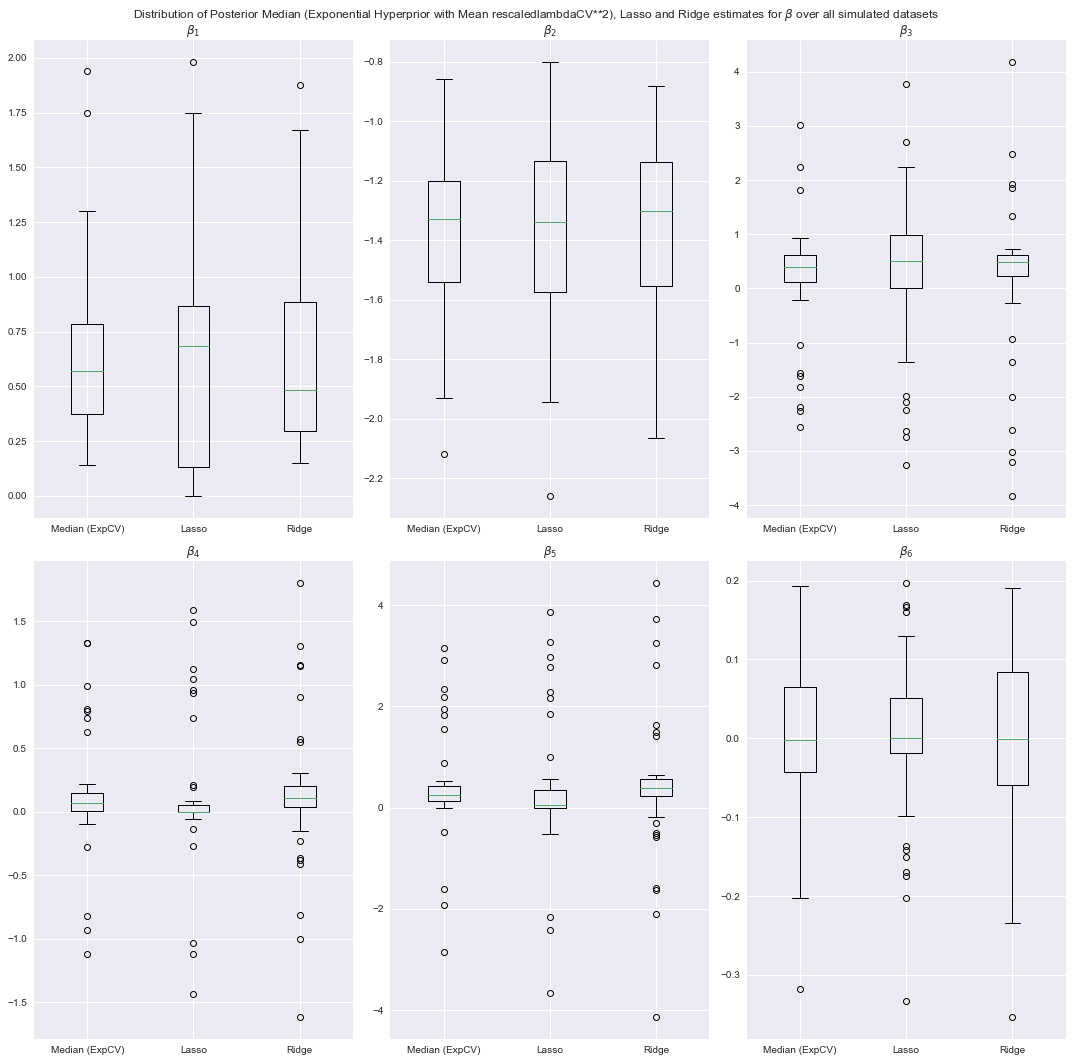

In [36]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (Exp Hyperprior with mean rescaledLambdaCV^{2}) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansExpCV[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (ExpCV)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (Exponential Hyperprior with Mean rescaledlambdaCV**2), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [37]:
"""
(6) Set the Pulse Prior for lambda^2 with mode = lambdaMML^{2} and variance = 1+(1/lambdaMML^{4})
    r = 1+lambdaMML^{4}, delta = lambdaMML^{2} 
"""

'\n(6) Set the Pulse Prior for lambda^2 with mode = lambdaMML^{2} and variance = 1+(1/lambdaMML^{4})\n    r = 1+lambdaMML^{4}, delta = lambdaMML^{2} \n'

In [38]:
# (6) Gamma prior with r = 1+lambdaMML^{4} and delta = lambdaMML^{2}

N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesPulseMML = np.zeros((num_datasets,N,p))
sig2TracesPulseMML = np.zeros((num_datasets,N))
tau2TracesPulseMML = np.zeros((num_datasets,N,p))
lambdaTracesPulseMML = np.zeros((num_datasets,N))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Find Bayesian Lasso traces using the Exponential prior for lambda**2 with mean at the squared MML estimate
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesPulseMML[datasetidx], sig2TracesPulseMML[datasetidx], tau2TracesPulseMML[datasetidx], lambdaTracesPulseMML[datasetidx]  = bLasso_i.gibbs_gammaHPrior(r=1+(lambdaMMLs[datasetidx])**4,delta=lambdaMMLs[datasetidx]**2,n_iter=N) 

0
10
20
30
40


In [39]:
betaBurnedTracesPulseMML = betaTracesPulseMML[:,burnin:,:]
sig2BurnedTracesPulseMML = sig2TracesPulseMML[:,burnin:]
tau2BurnedTracesPulseMML = tau2TracesPulseMML[:,burnin:,:]
lambdaBurnedTracesPulseMML = lambdaTracesPulseMML[:,burnin:]
betaBurnedTracesPulseMML.shape,sig2BurnedTracesPulseMML.shape,tau2BurnedTracesPulseMML.shape,lambdaBurnedTracesPulseMML.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6), (50, 5500))

In [40]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansPulseMML = np.median(betaBurnedTracesPulseMML,axis=1)
print(burnedBetaMediansPulseMML.shape)

(50, 6)


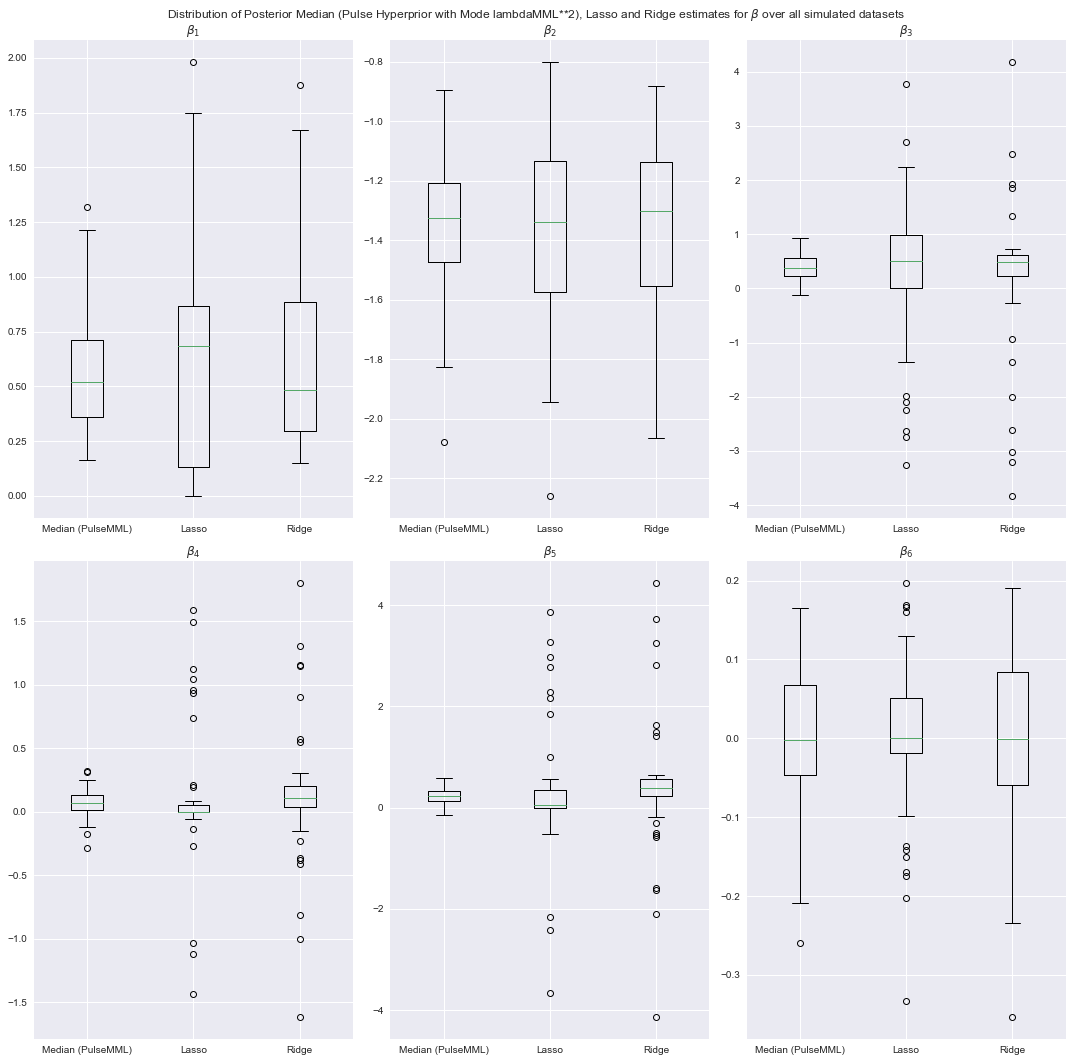

In [41]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (Pulse Hyperprior with mode lambdaMML**2) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansPulseMML[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (PulseMML)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (Pulse Hyperprior with Mode lambdaMML**2), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

In [42]:
"""
(7) Set the Pulse Prior for lambda^2 with mode = squared rescaled lambdaCV
    r = 1+rescaledlambdaCV^{4}, delta = rescaledlambdaCV^{2} 
"""

'\n(7) Set the Pulse Prior for lambda^2 with mode = squared rescaled lambdaCV\n    r = 1+rescaledlambdaCV^{4}, delta = rescaledlambdaCV^{2} \n'

In [43]:
N = 7500 # Number of steps of the MCMC algorithm
burnin = 2000

# I now create space to hold the traces for each dataset
num_datasets = datasets.shape[0]
n = datasets.shape[1]
p = datasets.shape[2]

betaTracesPulseCV = np.zeros((num_datasets,N,p))
sig2TracesPulseCV = np.zeros((num_datasets,N))
tau2TracesPulseCV = np.zeros((num_datasets,N,p))
lambdaTracesPulseCV = np.zeros((num_datasets,N))

# Calculate samples 
for datasetidx in range(num_datasets):
    if (datasetidx % 10 == 0):
        # Track progress
        print(datasetidx)
    # Standardise design matrix
    stdX = (datasets[datasetidx] - np.mean(datasets[datasetidx],axis=0))/np.std(datasets[datasetidx],axis=0)
    # Rescale lambda
    linearmodel = sm.OLS(responses[datasetidx]-np.mean(responses[datasetidx]),stdX).fit()
    RSS = np.sum(linearmodel.resid**2)
    s2 = RSS/(n-p)
    rescaledLambdaCV = lambdaLassoCVs[datasetidx]/(2*np.sqrt(s2))
    # Find Bayesian Lasso traces using the Pulse prior for lambda**2 with mode at the squared rescaled CV estimate
    bLasso_i = BayesianLasso(stdX,responses[datasetidx])
    betaTracesPulseCV[datasetidx], sig2TracesPulseCV[datasetidx], tau2TracesPulseCV[datasetidx], lambdaTracesPulseCV[datasetidx]  = bLasso_i.gibbs_gammaHPrior(r=1+(rescaledLambdaCV)**4,delta=rescaledLambdaCV**2,n_iter=N) 

0
10
20
30
40


In [44]:
betaBurnedTracesPulseCV = betaTracesPulseCV[:,burnin:,:]
sig2BurnedTracesPulseCV = sig2TracesPulseCV[:,burnin:]
tau2BurnedTracesPulseCV = tau2TracesPulseCV[:,burnin:,:]
lambdaBurnedTracesPulseCV = lambdaTracesPulseCV[:,burnin:]
betaBurnedTracesPulseCV.shape,sig2BurnedTracesPulseCV.shape,tau2BurnedTracesPulseCV.shape,lambdaBurnedTracesPulseCV.shape

((50, 5500, 6), (50, 5500), (50, 5500, 6), (50, 5500))

In [45]:
# For each dataset and beta_i, calculate the median
burnedBetaMediansPulseCV = np.median(betaBurnedTracesPulseCV,axis=1)
print(burnedBetaMediansPulseCV.shape)

(50, 6)


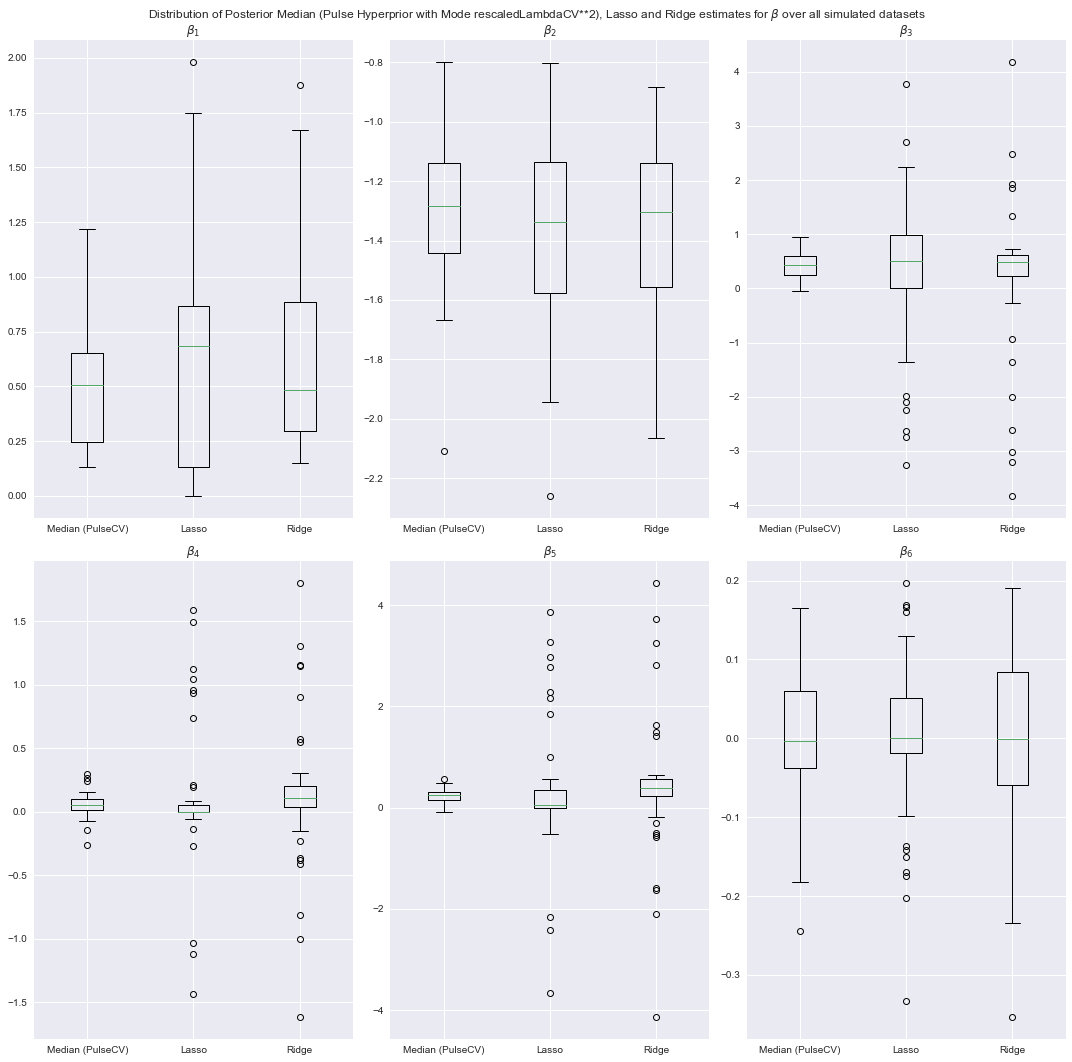

In [46]:
# Now make boxplots for each parameter - 9 separate plots
""" Each plot contains three boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (Pulse Hyperprior with mode rescaledLambdaCV**2) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansPulseCV[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["Median (PulseCV)", "Lasso", "Ridge"])
fig.suptitle(r"Distribution of Posterior Median (Pulse Hyperprior with Mode rescaledLambdaCV**2), Lasso and Ridge estimates for $\beta$ over all simulated datasets")
plt.tight_layout()
plt.show()

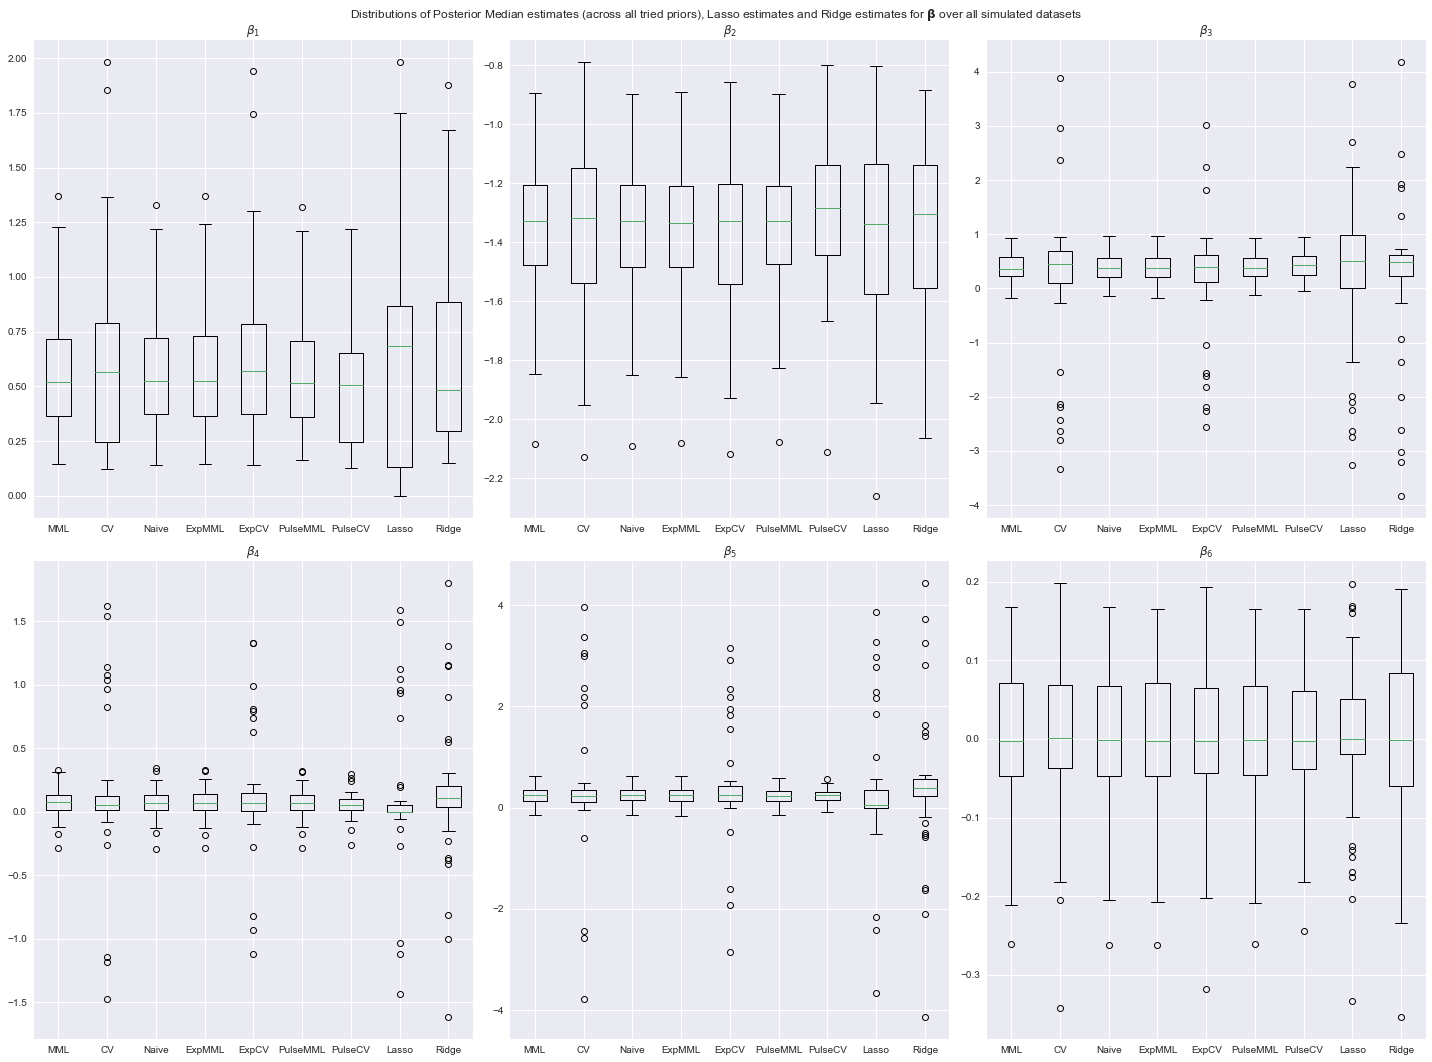

In [47]:
# Compare results from all priors, as well as ridge and lasso
# Now make boxplots for each parameter - 9 separate plots

""" Each plot contains boxplots showing the distribution of lasso, ridge and bayesian posterior median
    estimates (with each prior) across the 50 datasets"""

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,15))

for row in range(2):
    for col in range(3):
        ax[row][col].set_title(fr"$\beta_{{{3*(row)+col+1}}}$")
        ax[row][col].boxplot([burnedBetaMediansMML[:,3*(row)+col],burnedBetaMediansCV[:,3*(row)+col],burnedBetaMediansNaive[:,3*(row)+col],burnedBetaMediansExpMML[:,3*(row)+col],burnedBetaMediansExpCV[:,3*(row)+col],burnedBetaMediansPulseMML[:,3*(row)+col],burnedBetaMediansPulseCV[:,3*(row)+col],lassoCoefficientsCV[:,3*(row)+col],ridgeCoefficientsCV[:,3*(row)+col]])
        ax[row][col].set_xticklabels(["MML","CV","Naive","ExpMML","ExpCV", "PulseMML", "PulseCV", "Lasso", "Ridge"])
fig.suptitle(r"Distributions of Posterior Median estimates (across all tried priors), Lasso estimates and Ridge estimates for $\mathbf{\beta}$ over all simulated datasets")
plt.tight_layout()
plt.show()
